In [7]:
from FastCCM import CCM, CCM_utils
from FastCCM.utils import utils
from FastCCM.data.data_loader import get_truncated_lorenz_rand, get_truncated_rossler_lorenz_rand
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

In [8]:
ccm = CCM.PairwiseCCM(device="cpu")

**CCM for joint Rossler-Lorenz attractor**

In [9]:
X = get_truncated_rossler_lorenz_rand(400,40000,alpha=6, C=2)

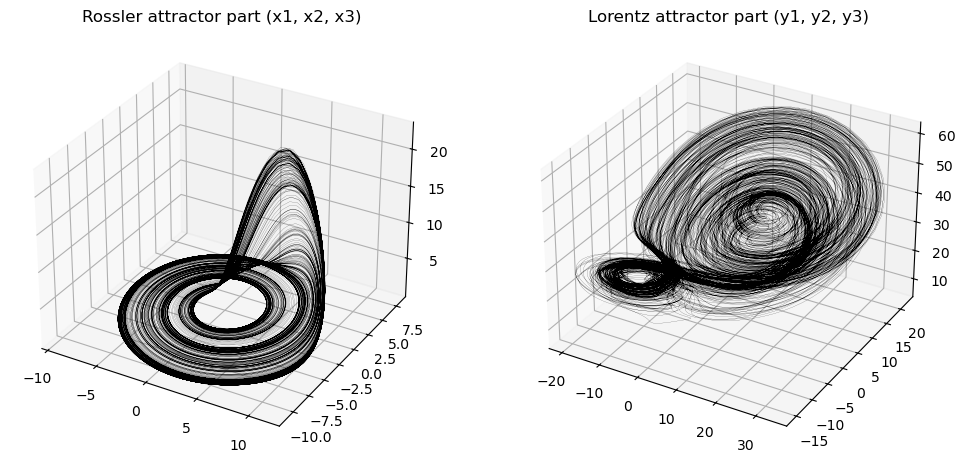

In [10]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(*X[:,[0, 1, 2]].T, lw=0.1,color="black"),
ax1.set_title('Rossler attractor part (x1, x2, x3)')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(*X[:, [4, 3, 5]].T,lw=0.1,color="black")
ax2.set_title('Lorentz attractor part (y1, y2, y3)')

plt.show()

(non-time-delay-embedded) Rossler xmap Lorenz

In [11]:
ccm.compute(X[:,:3][None],X[:,3:][None],subset_size=5000,subsample_size=1500,exclusion_rad=50,tp=0,method="simplex").mean()

0.74584055

(non-time-delay-embedded) Lorentz xmap Rossler

In [12]:
ccm.compute(X[:,3:][None],X[:,:3][None],subset_size=5000,subsample_size=1500,exclusion_rad=50,tp=0,method="simplex").mean()

0.71126413

Demonstration of convergence and variation of approximation

In [13]:
conv_test_res = CCM_utils.Functions("cpu").convergence_test(X = X[:,:3][None], Y = X[:,3:][None],
                                       subset_sizes = [80, 160, 320, 640, 1250, 2500, 5000, 10000, 20000,40000],
                                       subsample_size=1000, exclusion_rad=20, tp=0, method="simplex",trials=20)

<Axes: title={'center': 'Convergence Test Visualization'}, xlabel='Library Size', ylabel='Pearson Correlation Coefficient'>

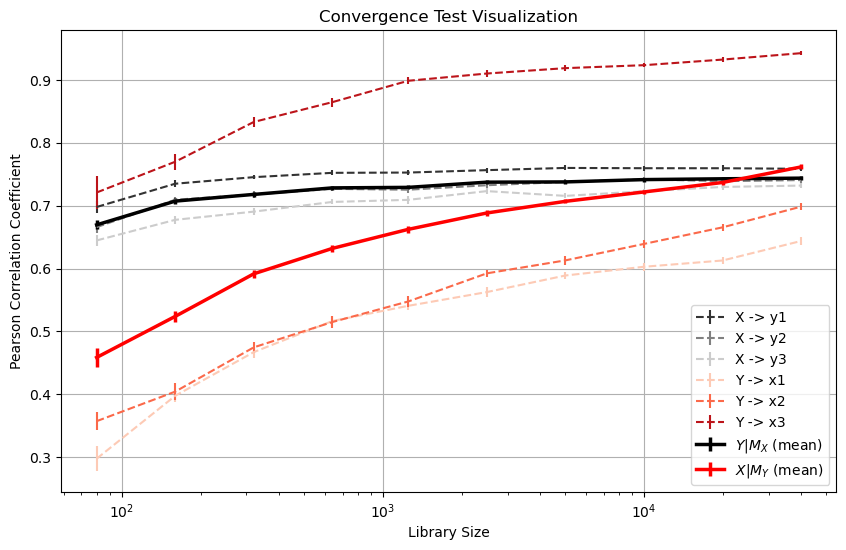

In [14]:
CCM_utils.Visualizer().plot_convergence_test(conv_test_res)

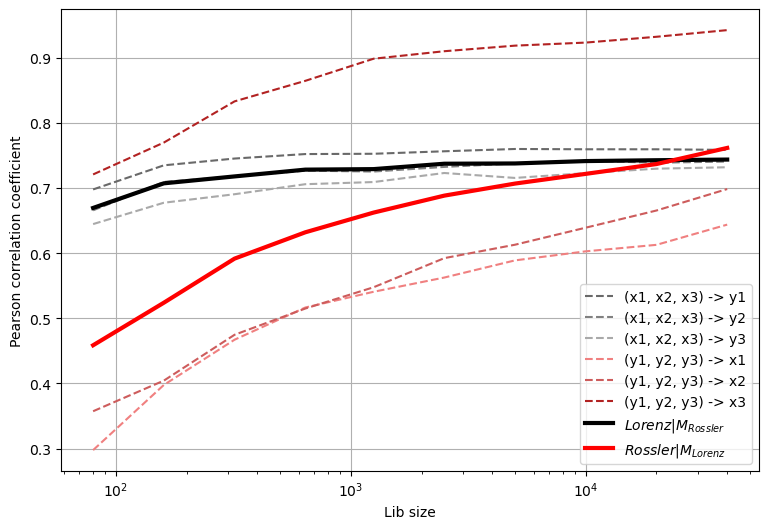

In [15]:
# Plot for (x1, x2, x3) -> y1, y2, y3 using shades of black/gray
plt.figure(figsize=(9,6))
plt.plot(conv_test_res["subset_sizes"], conv_test_res["X_to_Y"].mean(axis=1)[:, 0, 0, 0], "--",label="(x1, x2, x3) -> y1", color="dimgray")
plt.plot(conv_test_res["subset_sizes"], conv_test_res["X_to_Y"].mean(axis=1)[:, 1, 0, 0], "--",label="(x1, x2, x3) -> y2", color="gray")
plt.plot(conv_test_res["subset_sizes"], conv_test_res["X_to_Y"].mean(axis=1)[:, 2, 0, 0], "--",label="(x1, x2, x3) -> y3", color="darkgray")

# Plot for (y1, y2, y3) -> x1, x2, x3 using shades of red
plt.plot(conv_test_res["subset_sizes"], conv_test_res["Y_to_X"].mean(axis=1)[:, 0, 0, 0], "--", label="(y1, y2, y3) -> x1", color="lightcoral")
plt.plot(conv_test_res["subset_sizes"], conv_test_res["Y_to_X"].mean(axis=1)[:, 1, 0, 0], "--",label="(y1, y2, y3) -> x2", color="indianred")
plt.plot(conv_test_res["subset_sizes"], conv_test_res["Y_to_X"].mean(axis=1)[:, 2, 0, 0], "--",label="(y1, y2, y3) -> x3", color="firebrick")

plt.plot(conv_test_res["subset_sizes"], conv_test_res["X_to_Y"].mean(axis=1)[:,:,0,0].mean(axis=1),
        label="$Lorenz|M_{Rossler}$",
        lw=3,c="black")

plt.plot(conv_test_res["subset_sizes"], conv_test_res["Y_to_X"].mean(axis=1)[:,:,0,0].mean(axis=1),
        label="$Rossler|M_{Lorenz}$",
        lw=3,c="red",
        )
plt.xscale("log")
plt.xlabel("Lib size")
plt.ylabel("Pearson correlation coefficient")
plt.grid()
plt.legend()

Alternative:

In [21]:
sizes = [80, 160, 320, 640, 1280, 2560, 5120, 10240, 20480]

res_p_XY = []
for i in sizes:
    for e in range(20):
        res_p_XY += [ccm.compute(X[:,:3][None],X[:,3:][None],subset_size=100000,subsample_size=i,exclusion_rad=20,tp=0,method="simplex",nbrs_num = 10).mean()]
res_p_XY = np.array(res_p_XY).reshape(-1,20)

res_p_YX= []
for i in sizes:
    for e in range(20):
        res_p_YX += [ccm.compute(X[:,3:][None],X[:,:3][None],subset_size=100000,subsample_size=i,exclusion_rad=20,tp=0,method="simplex",nbrs_num = 10).mean()]
res_p_YX = np.array(res_p_YX).reshape(-1,20)

In [22]:
res_l_XY = []
for i in sizes:
    for e in range(20):
        res_l_XY += [ccm.compute(X[:,:3][None],X[:,3:][None],subset_size=i,subsample_size=100000,exclusion_rad=20,tp=0,method="simplex",nbrs_num = 10).mean()]
res_l_XY = np.array(res_l_XY).reshape(-1,20)

res_l_YX = []
for i in sizes:
    for e in range(20):
        res_l_YX += [ccm.compute(X[:,3:][None],X[:,:3][None],subset_size=i,subsample_size=100000,exclusion_rad=20,tp=0,method="simplex",nbrs_num = 10).mean()]
res_l_YX = np.array(res_l_YX).reshape(-1,20)

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title("Effect of changing $p$. $l = 80000$")
plt.errorbar(sizes,res_p_XY.mean(axis=1),yerr=res_p_XY.std(axis=1),capsize=5, color="black", label="$Lorenz|M_{Rossler}$")
plt.errorbar(sizes,res_p_YX.mean(axis=1),yerr=res_p_YX.std(axis=1),capsize=5, color="red", label="$Rossler|M_{Lorenz}$")
plt.ylabel("Pearson correlation coefficient")
plt.xlabel("Pred size")
plt.legend()
plt.xscale("log")

plt.subplot(1,2,2)
plt.title("Effect of changing $l$. $p = 80000$")
plt.errorbar(sizes,res_l_XY.mean(axis=1),yerr=res_l_XY.std(axis=1),capsize=5, color="black", label="$Lorenz|M_{Rossler}$")
plt.errorbar(sizes,res_l_YX.mean(axis=1),yerr=res_l_YX.std(axis=1),capsize=5, color="red", label="$Rossler|M_{Lorenz}$")
plt.xscale("log")
plt.xlabel("Lib size")
plt.legend()

**Optimal E and Tau**

In [17]:
x = X[:,3]#get_truncated_lorenz_rand(400,n_steps=20000)[:,0]

optimal_E_tau_res = CCM_utils.Functions("cpu").find_optimal_embedding_params(x, x, 2000, 500, exclusion_rad=10,
                                                         E_range=np.arange(2,30),
                                                         tau_range=np.arange(1,30),
                                                         tp_max=50,
                                                         method="simplex",trials=1, nbrs_num = 5)

In [ ]:
optimal_E_tau_res["optimal_E"], optimal_E_tau_res["optimal_tau"]

In [ ]:


# Example data from the optimal_E_tau_res dictionary
result = optimal_E_tau_res["result"].mean(axis=0)
E_range = optimal_E_tau_res["E_range"]
tau_range = optimal_E_tau_res["tau_range"]

# Create the plot using imshow for more flexibility
plt.figure(figsize=(10, 8))
plt.imshow(result, aspect='auto', extent=[E_range[0], E_range[-1], tau_range[0], tau_range[-1]], origin='lower')

# Set axis labels and title
plt.colorbar(label='Mean CCM Value')
plt.xlabel('Embedding Dimension (E)')
plt.ylabel('Time Delay (tau)')
plt.title('Optimal E and Tau Analysis')

# Set ticks for log scale
plt.xticks(E_range, labels=E_range)
plt.yticks(tau_range, labels=tau_range)

plt.show()


**5 independent Lorentz systems, each coordinate time delay embedded into 5 dimensions. All pairwise CCM.**

In [31]:
N_sys = 5

# Generate X axes of Lorenz systems starting from different initial state
X = np.concatenate([get_truncated_lorenz_rand(280,n_steps=30000).T for i in range(N_sys)])

X_emb = [utils.get_td_embedding_np(x[:,None],5,30,return_pred=False)[:,:,0] for x in X]

In [ ]:
np.array(X_emb).shape

In [ ]:
plt.matshow(ccm.compute(X_emb,X_emb,subset_size=2000,subsample_size=500,exclusion_rad=30,tp=100,method="simplex",nbrs_num = 10)[0],vmax=1,vmin=0)


**Finding a prediction power for a range of Tp**

In [34]:
X = get_truncated_lorenz_rand(4000,n_steps=200000)[None]
Y = X

In [ ]:
X.shape, Y.shape

The naive way

In [ ]:
st = time.time()
res = [ccm.compute(X,Y,subset_size=5000,subsample_size=1000,exclusion_rad=50,tp=i,method="simplex",nbrs_num = 10)[0,0,0] for i in range(200)]
print(time.time()-st, "sec")
plt.plot(res)
plt.xlabel("Tp")
plt.ylabel("Rho")

The smart way

In [ ]:
interval = 200
X_ = X[:,:-(interval-1)]
Y_ = np.transpose(utils.get_td_embedding_np(Y[0],interval,1),axes=(1,0,2))
X_.shape, Y_.shape

In [ ]:
st = time.time()
res = ccm.compute(X_,Y_,subset_size=5000,subsample_size=1000,exclusion_rad=50,tp=0,method="simplex",nbrs_num = 10)[0,:,0]
print(time.time()-st, "sec")
plt.plot(res)

Automated:

In [ ]:
conv_test_res = CCM_utils.Functions("cpu").prediction_interval_test(x = X[0], y = X[0],
                                       subset_size = 10000,
                                       subsample_size=1000, exclusion_rad=20, max_tp=1000, method="simplex", nbrs_num = 5)

plt.plot(conv_test_res["tp_list"],conv_test_res["X_to_Y"][:,:,0].T, label=["x", "y", "z"])
plt.legend()
plt.xlabel("Prediction steps")
plt.ylabel("Pearson correlation coefficient")

In [ ]:
CCM_utils.Visualizer().plot_interval_prediction_test(conv_test_res)

**Prediction horizon with different subset sizes**

In [35]:
exp_num = 20
tmax = 4000
n_steps = 200000
interval = 250
sample_size = 500
subset_sizes = np.arange(1000,50000,1000)

exp_res = []
for i in range(exp_num):
    X = get_truncated_lorenz_rand(tmax,n_steps=n_steps)[None]
    Y = X[:,:,[0]]

    X_ = X[:,:-(interval-1)]
    Y_ = utils.get_td_embedding_np(Y[0],interval,1)[:,:,0].T[:,:,None]

    res = np.array([ccm.compute(X_,Y_,subset_size=i,subsample_size=sample_size,exclusion_rad=20,tp=0,method="simplex",nbrs_num = 10)[0,:,0] for i in subset_sizes])
    exp_res += [res]
exp_res = np.array(exp_res).mean(axis=0)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
cmap = cm.get_cmap('jet', subset_sizes.shape[0])
norm = plt.Normalize(subset_sizes.min(), subset_sizes.max())

for i in range(exp_res.shape[0]):
    ax.plot(tmax/n_steps * np.arange(interval), exp_res[i], color=cmap(i))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Subset size')

ax.set_xlabel("Prediction time")
ax.set_ylabel("Rho")
plt.title("Prediction horizon of X axis of the Lorentz system")
plt.show()

In [41]:
exp_num = 20
tmax = 4000
n_steps = 200000
interval = 250
sample_size = 500
subset_sizes = np.arange(1000,50000,1000)

exp_res = []
for i in range(exp_num):
    X = get_truncated_lorenz_rand(tmax,n_steps=n_steps)[None]
    Y = X[:,:,[0]]

    X_ = X[:,:-(interval-1)]
    Y_ = utils.get_td_embedding_np(Y[0],interval,1)[:,:,0].T[:,:,None]
    X_ = utils.get_td_embedding_np(X_[0],3,2).reshape(-1,3*3)[None]

    res = np.array([ccm.compute(X_,Y_,subset_size=i,subsample_size=sample_size,exclusion_rad=20,tp=0,method="simplex",nbrs_num = 10)[0,:,0] for i in subset_sizes])
    exp_res += [res]
exp_res = np.array(exp_res).mean(axis=0)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
cmap = cm.get_cmap('jet', subset_sizes.shape[0])
norm = plt.Normalize(subset_sizes.min(), subset_sizes.max())

for i in range(exp_res.shape[0]):
    ax.plot(tmax/n_steps * np.arange(interval), exp_res[i], color=cmap(i))

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Subset size')

ax.set_xlabel("Prediction time")
ax.set_ylabel("Rho")
plt.title("Prediction horizon of X axis of the Lorentz system\ncrossmapping from it's XYZ corrdinates with 3 time delays")
plt.show()

**S-map, simplex results consistancy**

In [41]:
res = []
for e in range(100):
    r_alpha = np.random.uniform(1,10)
    r_c = np.random.uniform(1,5)

    X = get_truncated_rossler_lorenz_rand(500,50000,alpha=r_alpha, C=r_c)

    smpl = ccm.compute(X[:,:3][None],X[:,3:][None],5000,500,50,tp=0,method="simplex",nbrs_num = 20).mean()
    smap = ccm.compute(X[:,:3][None],X[:,3:][None],5000,500,50,tp=0,method="smap",theta = 10).mean()
    res += [[smpl, smap]]
res = np.array(res)

In [ ]:
plt.scatter(*res.T)

In [3]:
X = get_truncated_rossler_lorenz_rand(500,50000,alpha=4, C=2)

In [191]:
nbrs_num_range = np.arange(1,51)
omega_range = np.linspace(0.1,20,50)

res_smpl = []
res_smap = []
for e in range(50):
    smpl = []
    smap = []

    for nbrs_num in nbrs_num_range:
        smpl += [ccm.compute(X[:,:3][None],X[:,3:][None],5000,500,50,tp=0,method="simplex",nbrs_num = nbrs_num).mean()]

    for omega in omega_range:
        smap += [ccm.compute(X[:,:3][None],X[:,3:][None],5000,500,50,tp=0,method="smap",omega = omega).mean()]

    res_smpl += [smpl]
    res_smap += [smap]

res_smpl = np.array(res_smpl)
res_smap = np.array(res_smap)

---

Unsorted 


In [ ]:
X.mean(axis=0)

In [20]:
X = get_truncated_lorenz_rand(400,n_steps=20000)
X -= X.mean(axis=0)
X /= X.std(axis=0)

In [ ]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(*X[:,[0, 1, 2]].T, lw=0.1,color="black"),


In [52]:
ccm = CCM.PairwiseCCM(device="cuda")

In [9]:
import numpy as np

def rotation_matrix_z(theta):
    """Create a rotation matrix that rotates points around the z-axis by angle theta."""
    theta = np.radians(theta)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    return np.array([
        [cos_theta, -sin_theta, 0],
        [sin_theta,  cos_theta, 0],
        [       0,         0, 1]
    ])

def projection_matrix():
    """Create a projection matrix that projects 3D points into the xy-plane (2D)."""
    return np.array([
        [0, 1, 0],
        [0, 0, 1]
    ])

def combined_matrix(theta):
    """Create a combined matrix that rotates points around the z-axis by theta and projects to 2D."""
    R_z = rotation_matrix_z(theta)
    P = projection_matrix()
    # Combine the rotation matrix and the projection matrix
    return P @ R_z

# Generate matrices for a range of angles from 0 to 360 degrees
angles = np.linspace(0, 360, 10)  # You can adjust the number of angles here

matrices = [combined_matrix(angle) for angle in angles]



In [34]:

def rotation_matrix_z(theta):
    """
    Create a rotation matrix for a given angle theta around the z-axis.
    
    Args:
    theta (float): Angle in degrees.
    
    Returns:
    np.ndarray: 3x3 rotation matrix.
    """
    theta_rad = np.radians(theta)
    cos_theta = np.cos(theta_rad)
    sin_theta = np.sin(theta_rad)
    
    return np.array([
        [1, 0,0],
        [ 0,cos_theta,  -sin_theta],
        [0, sin_theta,cos_theta],
    ])

# Generate rotation matrices for a range of angles from 0 to 360 degrees in steps of 10 degrees
angles = np.arange(0, 361, 1)
rotation_matrices = [rotation_matrix_z(angle) for angle in angles]


In [ ]:
plt.plot(*(X[:,[0, 1, 2]]@ rotation_matrices[12])[:,[0,2]].T)

In [43]:
p = []
s = []

for r in rotation_matrices:
    Y = (X @ r)[:,[0,2]]
    s += [np.mean([ccm.compute(Y[None],Y[None],2000,300,50,tp=50,method="smap",omega = 10).mean() for e in range(10)])]
    p += [Y]

In [ ]:
plt.plot(s)

In [53]:
s = []
a = []
for i in range(10000):
    A = np.random.normal(0,1,(3,2))
    Y = X @ A
    s += [np.mean([ccm.compute(Y[None],Y[None],2000,300,50,tp=50,method="smap",omega = 5).mean() for e in range(10)])]
    a += [A]

In [ ]:
plt.plot(np.sort(s))

In [14]:
def compute_similarity(A, B):
    similarity = 0
    for k in range(A.shape[1]):
        col_A = A[:, k]
        col_B = B[:, k]
        norm_A = np.linalg.norm(col_A)
        norm_B = np.linalg.norm(col_B)
        dot_product = np.dot(col_A, col_B)
        similarity += dot_product / (norm_A * norm_B)
    return similarity

def compute_distance_matrix(matrices):
    n = len(matrices)
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):
            similarity = compute_similarity(matrices[i], matrices[j])
            distance = 1 - similarity
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance  # since the distance is symmetric

    return distance_matrix

In [56]:
dist = compute_distance_matrix(a)

In [59]:
import umap
uu = umap.UMAP(15)
x_umap = uu.fit_transform(dist)

In [ ]:
plt.scatter(*x_umap.T,c=s,vmax=0.8,vmin=0.4)

In [163]:
import numpy as np

def create_rotation_matrix_2d(theta):
    """
    Create a 2D rotation matrix for a given angle theta.
    """
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

def project_3d_to_2d(rotation_angle_1, rotation_angle_2):
    """
    Generate a 3x2 projection matrix from 3D to 2D, with specified rotation angles for the two eigenvectors.
    """
    # Define two orthonormal vectors in 3D space
    e1 = np.array([1, 0, 0])
    e2 = np.array([0, 1, 0])
    
    # Generate 2D rotation matrices for the given angles
    R1 = create_rotation_matrix_2d(np.deg2rad(rotation_angle_1))
    R2 = create_rotation_matrix_2d(np.deg2rad(rotation_angle_2))
    
    # Project the 3D vectors onto the 2D plane and apply the rotations
    P = np.zeros((3, 2))
    P[:2, 0] = e1[:2].dot(R1)
    P[:2, 1] = e2[:2].dot(R2)
    
    return P

def generate_projection_matrices(start_angle, end_angle, step):
    """
    Generate projection matrices for a range of rotation angles for both eigenvectors.
    """
    projection_matrices = []
    for angle1 in range(start_angle, end_angle + step, step):
        for angle2 in range(start_angle, end_angle + step, step):
            P = project_3d_to_2d(angle1, angle2)
            projection_matrices.append((angle1, angle2, P))
    return projection_matrices

# Example usage:
start_angle = 0
end_angle = 360
step = 5  # Step size for the angles

projection_matrices = generate_projection_matrices(start_angle, end_angle, step)



In [ ]:
plt.plot(*(X[:,[1,2,0]] @ projection_matrices[500][2]).T)

In [164]:

s = []

for r in projection_matrices:
    Y = (X[:,[1,0,2]] @ (r[2]+np.random.normal(0,0.001,(3,2))))
    s += [np.mean([ccm.compute(Y[None],Y[None],2000,300,50,tp=50,method="smap",omega = 10).mean() for e in range(3)])]


In [ ]:
plt.matshow(np.array(s).reshape(73,73))
plt.colorbar()

In [59]:
X = get_truncated_lorenz_rand(800,n_steps=40000)

In [73]:
Z_embs = np.concatenate(np.array([[utils.get_td_embedding_np(X[:,[2]],i,j)[:,:,0] for i in range(1,40)] for j in range(1,40)],dtype="object"))

In [89]:
ccm = CCM.PairwiseCCM("cpu")

res = ccm.compute(Z_embs, X[:,0][None,:,None],
            5200,1200,30,20,0
                 )

In [ ]:
plt.matshow(res[0,0].reshape(39,39),vmin=0,vmax=0.15)
plt.colorbar()